# Image classifier

In [1]:
import numpy as np
import tensorflow as tf

2025-04-24 21:50:07.376919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745545807.392149  253556 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745545807.396976  253556 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745545807.408981  253556 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745545807.409010  253556 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745545807.409014  253556 computation_placer.cc:177] computation placer alr

# Load the data

In [2]:
import os


data_dir = os.path.abspath('/mnt/f/Courses/4GeeksAcademy/DataScience/DeliverableExercises/alejandroNovellino-image-classifier-project/data/raw/train_2')

# set the image width and height
img_width = 160
img_height = 160

batch_size = 16

# train dataset
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

Found 557 files belonging to 2 classes.
Using 446 files for training.
Using 111 files for validation.


I0000 00:00:1745545810.342513  253556 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6055 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:31:00.0, compute capability: 7.5


In [3]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [4]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [5]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


# Visualize the data

2025-04-24 21:50:11.627494: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


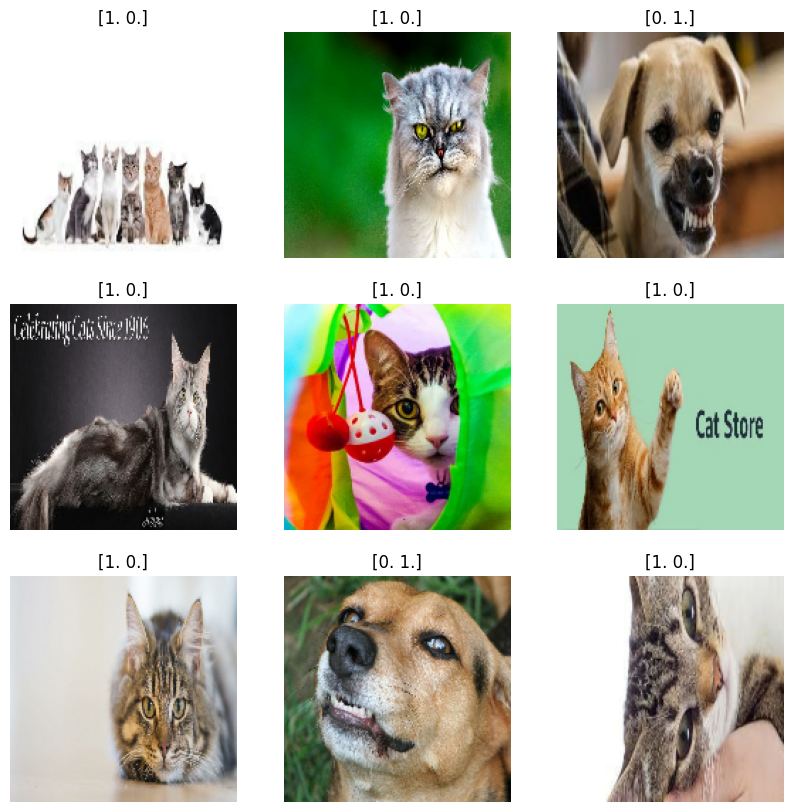

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(tf.keras.backend.get_value(labels[i]))
    plt.axis("off")

Let's verify what is the content of train_ds

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 160, 160, 3)
(16, 2)


The image_batch is a tensor of the shape (12, 120, 120, 3). This is a batch of 16 with shape 160x160x3 (the last dimension refers to color channels RGB and the images are 120x120 because that is the value we set on the **image_dataset_from_directory** function). The label_batch is a tensor of the shape (12,), these are corresponding **labels** to the 12 images.

# Configure the dataset for performance

We are going to use buffered prefetching, so we can yield data from disk without having I/O become blocking. The two important methods we should use when loading data are:

- **Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- **Dataset.prefetch** overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods.

In [8]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Now we standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [9]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)

Now there are two ways to use this layer. We can apply it to the dataset by calling Dataset.map:

In [10]:
# normalize all the data
# normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# let's print the first image to see the normalization
# image_batch, labels_batch = next(iter(normalized_train_ds))
# first_image = image_batch[0]
# print('Min and Max values:', np.min(first_image), '-', np.max(first_image))

Or we can include this layer in the model, the same can be done with the Resizing using the **tf.keras.layers.Resizing** layer (we are going to do this option).

# Now let's create the model (CNN)

This time we are following the models given to use:

In [11]:
from keras import Sequential, layers, regularizers


model = Sequential([
    # set this Input layer to delete the warning
    layers.Input(shape=(img_height, img_width, 3)),
    # here is where the rescaling layer can be
    layers.Rescaling(1./255),

    # rest of the layers
    layers.Conv2D(filters = 32, kernel_size = (3,3), padding = "same", activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    layers.Conv2D(filters = 32,kernel_size = (3,3),padding = "same", activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    layers.MaxPool2D(pool_size = (2,2),strides = (2,2)),
    # dropout layer
    layers.Dropout(0.5),

    layers.Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    layers.MaxPool2D(pool_size = (2,2),strides = (2,2)),
    # dropout layer
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(units = 512,activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    # dropout layer
    layers.Dropout(0.5),
    layers.Dense(units = 512,activation = "relu", kernel_regularizer=regularizers.L2(0.001)),
    # dropout layer
    layers.Dropout(0.5),

    # output layer
    layers.Dense(units = 2, activation = "softmax"),
])

# Compile the model

This time we are going to use the **tf.keras.optimizers.Adam** optimizer and **tf.keras.losses.SparseCategoricalCrossentropy** loss function.

In [12]:
model.compile(
    optimizer='adam',
    loss=['categorical_crossentropy'], # use this loss function based on the load labels that we used
    metrics=['accuracy'] # we can use accuracy because the training data is balanced
)

# Model summary

We can see all the layers of the network using the Keras **Model.summary** method:

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 160, 160, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 80, 80, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 102400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    52,429,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,758,562 (201.26 MB)

 Trainable params: 52,758,562 (201.26 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [14]:
# filter warnings to not see them during training (this is not working)
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

Early stopping conf

In [15]:
from keras.src.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',         # metric to verify
    patience=25,                 # number of epochs without change to stop
    restore_best_weights=True
)

Learning rate scheduler

In [16]:
from keras.src.callbacks import LearningRateScheduler


def scheduler(epoch, lr):
    """
    Scheduler that reduces the learning rate by 10.
    """
    if epoch < 10:
        return lr
    else:
        return lr * 0.1

lr_scheduler = LearningRateScheduler(scheduler)

Fitting of the model

In [17]:
# epoch to train
epochs = 100

# train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping],
    verbose=0
)

I0000 00:00:1745545814.658654  253789 service.cc:152] XLA service 0x35e75490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745545814.658701  253789 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2025-04-24 21:50:14.751762: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745545814.994351  253789 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-24 21:50:15.458379: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.12 = (f32[16,32,160,160]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,160,160]{3,2,1,0} %bitcast.13175, f32[32,3,3,3]{3,2,1,0} %bitcast.12818, f32[32]{0} %bitcast.13539), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_t

# Visualize training results

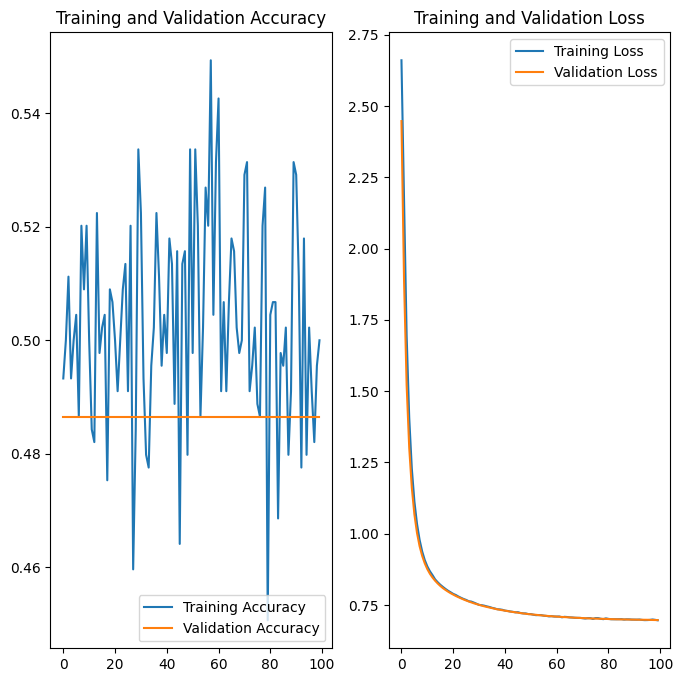

In [18]:
# get the values to graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['val_accuracy']))

# create the graphs
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Analysis

# Save the model

In [19]:
save_dir = os.path.abspath('/mnt/f/Courses/4GeeksAcademy/DataScience/DeliverableExercises/alejandroNovellino-image-classifier-project/models')

model.save(f'{save_dir}/model_2.keras')

Now clear the memory to continue working

In [20]:
from keras.src.backend.common.global_state import clear_session

clear_session(
    free_memory=True
)